##  The Problem Statement:


Snap-Shot LLC.  is a startup which specializes in building mirrorless digital cameras.  The company is planning to introduce a new line of above full frame digital cameras. Based on historical statistics of digital camera sales, a person earning more than specific income is more likely to buy an expensive camera.  Company decides to launch a marketing camping to targeted to specific set of potential customers who earn more than $50000 annually.

### Solution:

In [68]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import vtreat
import vtreat.util
from pprint import pprint
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
from sklearn.metrics import roc_auc_score,auc
from sklearn.metrics import plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

In [69]:
df = pd.read_pickle('df.pkl')
df_test = pd.read_pickle('df_test.pkl')

In [70]:
df_true = df[df.income == True]
df_false = df[df.income == False]
print ("Imabanced data set",(len(df_true)/ len(df))  * 100, "%" )

Imabanced data set 8.140643388274896 %


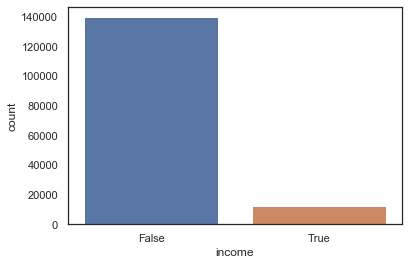

In [71]:
sns.countplot(x='income', data=df)

#### 3.2 : Define the metric used to evaluate model performance.

In [72]:
def evaluate_metrics(y_predict, y_test):
    """
    This function computes various model evaluation metrics for given data set.
    input: Arrays of true and predicted values.
    output: results of various metrics.
    
    """
    
    result = {}
    f1 = f1_score(y_test, y_predict)
    p = precision_score(y_test,y_predict)
    r = recall_score(y_test,y_predict)
    a = roc_auc_score(y_test,y_predict)
    c = confusion_matrix(y_test,y_predict)

    print ("F1 Score         : ", f1)
    print ("Precission Score : ", p)
    print ("Recall Score     : ", r)
    print ("roc_auc_score    : ",a )
    print ("Confusion Matrix : ",c)
    
    result['f1'] = f1
    result['p'] = p
    result['r'] = r
    result['a'] = a
    result['c'] = c
    
    return result

#### 3.3 Oversampling of minority class

In [73]:
from sklearn.utils import resample
def overample_minority(df, alpha):
    """
        This function oversamples the minority class to balance both the classes in the dataset.
        input: a dataframewith imbalanced classed.
        output: modified dataframe with balanced classes.
    """
    
# separate minority and majority classes
    above = df[df.income == True ]
    below = df[df.income == False]
    
    # upsample minority
    above_upsampled = resample(above,
                        replace=True, # sample with replacement
                        n_samples=int(len(below)/alpha), # match number in majority class
                        random_state=42) # reproducible results

    # combine majority and upsampled minority
    upsampled = pd.concat([above_upsampled, below])
    
    # check new class counts
    print(upsampled.income.value_counts())
  
    return upsampled

In [74]:
df_true = df[df.income == True]
df_false = df[df.income == False]
print ("Imabanced data set",(len(df_true)/ len(df))  * 100, "%" )

x=overample_minority(df,4)
x_true = x[x.income == True]
x_false = x[x.income == False]
print ("Imabanced data set",(len(x_true)/ len(x))  * 100, "%" )

Imabanced data set 8.140643388274896 %
False    139719
True      34929
Name: income, dtype: int64
Imabanced data set 19.999656451834547 %


In [75]:
df.to_pickle('df.pkl')
df_test.to_pickle('df_test.pkl')

In [76]:
df = pd.read_pickle('df.pkl')
df_test = pd.read_pickle('df_test.pkl')

### 5. Create Test,Train and Validation dataset

#### 5.1  One hot encoding

Since most of the fields in the dataset are categorical variables, sklearn does not handle categorical variables. One-hot encoders convert categorical variables into integers

In [77]:
def dummy_encode (df,df_test):
    """
    This function concats train and test dataset.  Converts the combined dataset for one hot encoding.
    The function returns the split train and test dataset.
    input parameters: trainset , testset.
    output parameters: one hot encoded train and test sets
    """
    df['Type'] = True
    df_test['Type'] = False
    combined_df = pd.concat([df,df_test])
    combinded_X = combined_df.loc[:, df.columns != 'income']
    combined_y = combined_df.income
    combined_df = pd.get_dummies(combinded_X, prefix_sep='__', columns=cat_cols)
    combined_df['income'] = combined_y
    df_new = combined_df[combined_df.Type == True]
    df_test_new = combined_df[combined_df.Type == False]
    df_new = df_new.drop(columns=['Type'])
    df_test_new = df_test_new.drop(columns=['Type'])
    df = df.drop(columns=['Type'])
    df_test.drop(columns=['Type'])
    return df_new, df_test_new

In [78]:
cat_cols = df.select_dtypes(include='category').columns
df_en, df_test_en = dummy_encode (df,df_test)

#### New dimensions of the data are

In [79]:
print(df_en.shape)
print(df_test_en.shape)

(152101, 503)
(76320, 503)


In [80]:
df_en_y = df_en['income']
df_en_X = df_en.drop(columns=['income'])

In [81]:
df_test_en_y = df_test_en['income']
df_test_en_X = df_test_en.drop(columns=['income'])

In [82]:
print(df_test_en_X.shape)
print(df_test_en_y.shape)

(76320, 502)
(76320,)


#### 5.2 Create a test and train data set from the df_en

In [83]:
X_en_train, X_en_test, y_en_train,y_en_test = train_test_split(df_en_X,df_en_y, random_state = 42, test_size =0.3)

####  5.3 Create default classifier 

In [84]:
names = ['RandomForestClassifier','AdaBoostClassifier','GaussianNB','GradientBoostingClassifier']
classifiers = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    GradientBoostingClassifier()
   ]

In [85]:
def find_classifier(names, classifiers,X_en_train,y_en_train,X_en_test,y_en_test,df_test_en_X,df_test_en_y):
    validation_metric = {}
    test_metric = {}
    print(names)
    for name, clf in zip(names, classifiers):
        print(name)
        clf.fit(X_en_train,y_en_train)
        y_en_predict = clf.predict(X_en_test)
        print("Validation Metrics :")
        validation_metric[name] = evaluate_metrics(y_en_test, y_en_predict)
        
        print("Test Metrics  :")
        y_df_predict = clf.predict(df_test_en_X)
        test_metric[name] = evaluate_metrics(df_test_en_y,y_df_predict)
      
    return validation_metric, test_metric

In [86]:
x,y = find_classifier(names,classifiers,X_en_train,y_en_train,X_en_test,y_en_test,df_test_en_X,df_test_en_y)

['RandomForestClassifier', 'AdaBoostClassifier', 'GaussianNB', 'GradientBoostingClassifier']
RandomForestClassifier
Validation Metrics :
F1 Score         :  0.4244912531238843
Precission Score :  0.31851058130190196
Recall Score     :  0.6361690743713215
roc_auc_score    :  0.7890182239458636
Confusion Matrix :  [[41218  2544]
 [  680  1189]]
Test Metrics  :
F1 Score         :  0.42487271151554545
Precission Score :  0.3170061429033301
Recall Score     :  0.6440065681444992
roc_auc_score    :  0.7931735331340032
Confusion Matrix :  [[69050  4225]
 [ 1084  1961]]
AdaBoostClassifier
Validation Metrics :
F1 Score         :  0.44396474186004675
Precission Score :  0.330565229038307
Recall Score     :  0.6757940854326396
roc_auc_score    :  0.8093729016365344
Confusion Matrix :  [[41306  2499]
 [  592  1234]]
Test Metrics  :
F1 Score         :  0.44477965736450814
Precission Score :  0.33365664403491757
Recall Score     :  0.6668820678513732
roc_auc_score    :  0.8052949089683632
Confusion 

In [87]:
classifiers[3]

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [88]:
importance = classifiers[3].feature_importances_
indices = importance.argsort()[::-1][:10]
features = X_en_train.columns
top_features = []
for i in indices[:20]:
    print(features[i])

weeksworked
age
majoroccode__ Executive admin and managerial
majoroccode__ Professional specialty
sex__ Male
sex__ Female
education__ Masters degree(MA MS MEng MEd MSW MBA)
education__ Prof school degree (MD DDS DVM LLB JD)
education__ Bachelors degree(BA AB BS)
education__ Doctorate degree(PhD EdD)


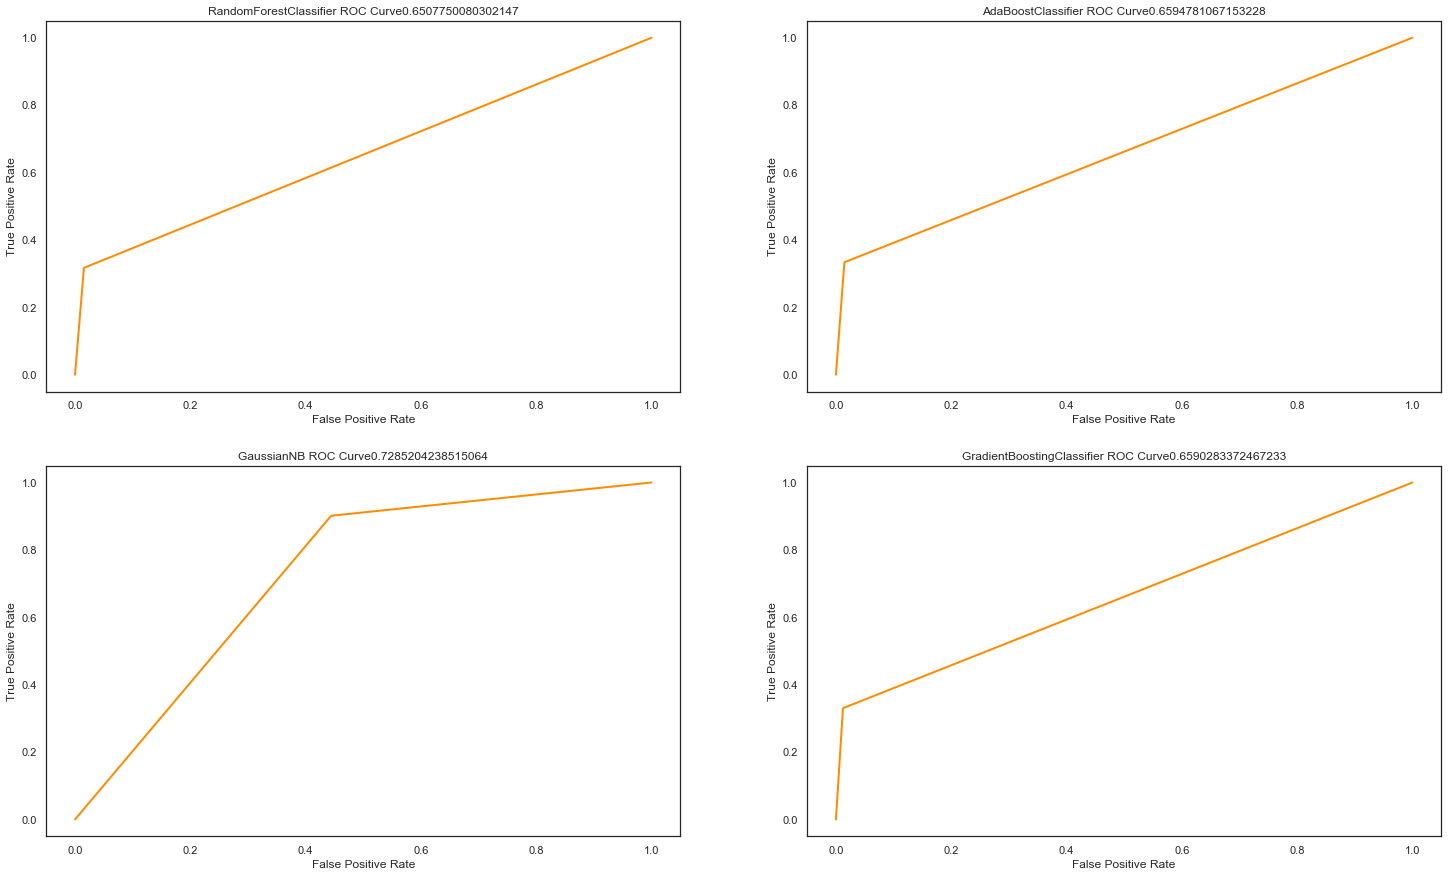

In [89]:
a4_dims = (25, 15)
fig, ax = plt.subplots(2,2,figsize=a4_dims)
aux = [[0,0],[0,1],[1,0],[1,1]]
lw=2
for i in range(0,len(classifiers)):
    y_predict = classifiers[i].predict(df_test_en_X)
    fpr,tpr,_ = roc_curve(df_test_en_y,y_predict)
    roc_auc = auc(fpr, tpr)
    x = aux[i][0]
    y = aux[i][1]
    ax[x,y].plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax[x,y].set(xlabel='False Positive Rate',ylabel="True Positive Rate")
    ax[x,y].set_title(names[i] + " ROC Curve" +  str(roc_auc))
  

### 6. Tunning the default model

The default model can be furtuer tuned to increase the performance.

#### 6.1 Oversampling the minority class

In [90]:
#Over Sample Minority class
ov_df = overample_minority(df,8)

False    139719
True      17464
Name: income, dtype: int64


In [91]:
ov_df_true = ov_df[ov_df.income == True]
ov_df_false = ov_df[ov_df.income == False]
print ("Imabanced data set",(len(ov_df_true)/ len(ov_df))  * 100, "%" )

Imabanced data set 11.11061628802097 %


#### 6.2  One hot encoding for the reshuffled data.

In [92]:
ov_df_en, ov_df_test_en = dummy_encode (ov_df,df_test)

In [93]:
ov_df_test_en_y = ov_df_test_en['income']
ov_df_test_en_X = ov_df_test_en.drop(columns=['income'])
ov_df_en_y = ov_df_en['income']
ov_df_en_X = ov_df_en.drop(columns=['income'])

#### 6.3 Hyper Parameter tuning using GridSearchCV

In [94]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2, 3,4],
    'min_samples_leaf': [1, 2,3,4],
    'min_samples_split': [1,2,3,5],
    'n_estimators': [50,100,150,300,1000 ]
}

# Create a based model
rf = GradientBoostingClassifier()
#Scoring
scorings = {'AUC': 'roc_auc', 'F1': 'f1'}


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, 
                               verbose = 2, scoring=scorings, refit='AUC', return_train_score=True)

In [95]:
ov_X_en_train, ov_X_en_test, ov_y_en_train,ov_y_en_test = \
                train_test_split(ov_df_en_X,ov_df_en_y, random_state = 42, test_size =0.3, stratify=ov_df_en_y)

In [96]:
grid_search.fit(ov_X_en_train, ov_y_en_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 88.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 186.6min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 226.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [97]:
best = grid_search.best_params_
results = grid_search.cv_results_
print(best)

{'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


In [98]:
clf = GradientBoostingClassifier(
                             max_features=best['max_features'], min_samples_leaf=best['min_samples_leaf'],
                            min_samples_split=best['min_samples_split'], n_estimators=best['n_estimators'])

In [99]:
clf.fit(ov_X_en_train, ov_y_en_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [100]:
importance = clf.feature_importances_
indices = importance.argsort()[::-1][:10]
features = ov_X_en_train.columns
top_features = []
for i in indices[:20]:
    print(features[i])

occupationcode__2
education__ Masters degree(MA MS MEng MEd MSW MBA)
weeksworked
sex__ Male
education__ Bachelors degree(BA AB BS)
education__ Doctorate degree(PhD EdD)
education__ Prof school degree (MD DDS DVM LLB JD)
age
workerclass__ Self-employed-incorporated
householdstat__ Householder


In [101]:
x = clf.predict(ov_X_en_test)
evaluate_metrics( ov_y_en_test,x)
f1 = f1_score(x, ov_y_en_test)
print(f1)

F1 Score         :  0.5444057204662901
Precission Score :  0.43233441496468794
Recall Score     :  0.7349123945489942
roc_auc_score    :  0.8337167195897468
Confusion Matrix :  [[41099  2974]
 [  817  2265]]
0.5444057204662901


In [102]:
ov_y_en_predict_df_test = clf.predict(ov_df_test_en_X)
evaluate_metrics(ov_df_test_en_y, ov_y_en_predict_df_test)

F1 Score         :  0.5007927070947285
Precission Score :  0.40850307145166503
Recall Score     :  0.6469534050179212
roc_auc_score    :  0.7982122508835843
Confusion Matrix :  [[68755  3659]
 [ 1379  2527]]


{'f1': 0.5007927070947285,
 'p': 0.40850307145166503,
 'r': 0.6469534050179212,
 'a': 0.7982122508835843,
 'c': array([[68755,  3659],
        [ 1379,  2527]])}

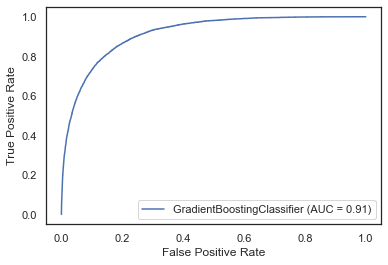

In [103]:
plot_roc_curve(clf,ov_df_test_en_X,ov_df_test_en_y)

### Conclusion


From the raw data only 6% percent of individuals have income greater than $50k. When faced with imbalanced data sets there is no one stop solution to improve the accuracy of the prediction model.  One may need to try out multiple methods to figure out the best-suited sampling techniques for the dataset. The model will help marketing deparment target potential customers with Higher precission and recall.


